# `StableSpectralElements.jl` - 2D linear advection example

First, let's load the packages used in this example.

In [17]:
using StableSpectralElements, OrdinaryDiffEq
using Plots, Plots.PlotMeasures, TimerOutputs

We will solve the two-dimensional linear advection equation
$$
\partial_t U(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot (\boldsymbol{a} U(\boldsymbol{x},t)) = 0,  \quad \forall\, (\boldsymbol{x}, t) \in \Omega \times (0,T),
$$
with $a = [1,1]^{\mathrm{T}}$ and $\Omega = (0,L)^2$, where we take $L = 1$, and $T = 1$, and impose periodic boundary conditions as well as the initial condition
$$
U(\boldsymbol{x},0) = \sin(2\pi x_1 / L)\sin(2\pi x_2 / L), \quad \forall \, \boldsymbol{x} \in \Omega.
$$

In [18]:
a = (1.0,1.0)  # advection velocity
L = 1.0  # domain length
T = 1.0  # end time

conservation_law = LinearAdvectionEquation(a)
exact_solution = InitialDataSine(1.0,(2π/L, 2π/L));

Let's discretize the above problem using a `NodalMulti` discretization of degree $p = 4$, on an isoparametric (i.e. $p_{\mathrm{map}} = p$) curved triangular mesh with $M = 4$ edges in each direction. A skew-symmetric split form will be used to treat the curvilinear coordinate transformation in a provably stable manner. A central numerical flux is used to obtain an energy-conservative scheme.

In [19]:
M = 4
p = 4

reference_approximation = ReferenceApproximation(
    NodalMulti(p), Tri(), mapping_degree=p)

form = StandardForm(mapping_form=SkewSymmetricMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux(0.0))

uniform_mesh = uniform_periodic_mesh(reference_approximation,
    ((0.0,L),(0.0,L)), (M,M))

mesh = warp_mesh(uniform_mesh, reference_approximation, 0.2, L)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation, project_jacobian=true)

results_path = save_project(conservation_law,
     spatial_discretization, exact_solution, form, (0.0, T),
    "results/advection_2d_tensor/", overwrite=true, clear=true);

We'll now plot the mesh, showing the volume and facet quadrature nodes.

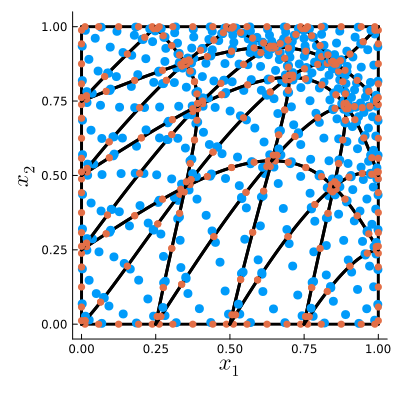

In [20]:
plot(spatial_discretization, fmt=:png)

Using the `semidiscretize` function, we can create an `ODEProblem` object for use with OrdinaryDiffEq.jl's `solve` function.

In [21]:
ode_problem = semidiscretize(conservation_law,
    spatial_discretization, exact_solution, form, (0.0, T))

CFL = 0.02
h = L/sqrt(reference_approximation.N_p * spatial_discretization.N_e)
dt = CFL * h / sqrt(a[1]^2 + a[2]^2)

reset_timer!()
sol = solve(ode_problem, CarpenterKennedy2N54(), 
    adaptive=false, dt=dt, save_everystep=false, 
    callback=save_callback(results_path, (0.0,T), floor(Int, T/(dt*50))))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            4.52s /  98.3%           1.10GiB /  99.8%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 semi-disc. residual    8.06k    4.44s  100.0%   551μs   1.10GiB  100.0%   144KiB
 ────────────────────────────────────────────────────────────────────────────────


The $L^2$ error in the numerical solution can then be computed as follows using the scheme's volume quadrature rule.

In [22]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T)...)

L2 error:
0.04730256824765629


The conservation and energy functionals can now be evaluated as shown below. The scheme is conservative on the order of machine precision, and energy dissipation is only introduced through the time discretization.

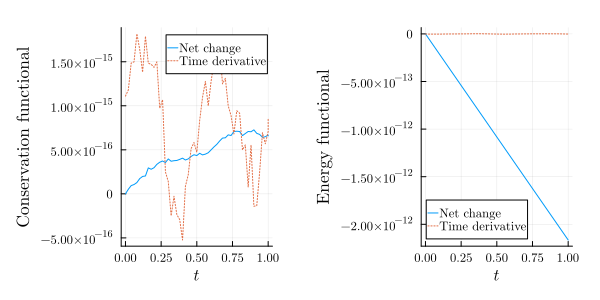

In [23]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Conservation functional")
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), 
    ylabel="Energy functional")
plot(p1,p2, size=(600,300),margin=5mm, fmt=:png)

Using a low-order subdivision of the high-order elements, we can generate `.vtu` solution files for visualization, for example, using ParaView.

In [24]:
postprocess_vtk(spatial_discretization, string(results_path,"solution.vtu"), last(sol.u));